**STEP 1 – Environment Setup**

In [1]:
!pip install torch torchvision torchaudio nibabel matplotlib numpy scikit-learn


**STEP 2 – Implement Enhanced U-Net (Segmentation)**

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm2d(out_ch)
        self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(out_ch)
        self.skip  = nn.Conv2d(in_ch, out_ch, kernel_size=1) if in_ch != out_ch else nn.Identity()

    def forward(self, x):
        identity = self.skip(x)
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += identity
        out = F.relu(out)
        return out

class AttentionGate(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super().__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1),
            nn.BatchNorm2d(F_int)
        )
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1),
            nn.BatchNorm2d(F_int)
        )
        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

    def forward(self, g, x):
        # g: coarse feature (decoder), x: skip feature (encoder)
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = F.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi

class EnhancedUNet(nn.Module):
    def __init__(self, in_channels=4, num_classes=4):  # WT/TC/ET/background
        super().__init__()
        filters = [64, 128, 256, 512, 1024]

        # Encoder
        self.rb1 = ResidualBlock(in_channels, filters[0])
        self.pool1 = nn.MaxPool2d(2)

        self.rb2 = ResidualBlock(filters[0], filters[1])
        self.pool2 = nn.MaxPool2d(2)

        self.rb3 = ResidualBlock(filters[1], filters[2])
        self.pool3 = nn.MaxPool2d(2)

        self.rb4 = ResidualBlock(filters[2], filters[3])
        self.pool4 = nn.MaxPool2d(2)

        # Bottleneck
        self.rb5 = ResidualBlock(filters[3], filters[4])
        self.dropout = nn.Dropout2d(p=0.3)

        # Attention gates
        self.ag4 = AttentionGate(F_g=filters[3], F_l=filters[3], F_int=filters[2])
        self.ag3 = AttentionGate(F_g=filters[2], F_l=filters[2], F_int=filters[1])
        self.ag2 = AttentionGate(F_g=filters[1], F_l=filters[1], F_int=filters[0])
        self.ag1 = AttentionGate(F_g=filters[0], F_l=filters[0], F_int=filters[0]//2)

        # Decoder
        self.up4 = nn.ConvTranspose2d(filters[4], filters[3], kernel_size=2, stride=2)
        self.rb6 = ResidualBlock(filters[4], filters[3])

        self.up3 = nn.ConvTranspose2d(filters[3], filters[2], kernel_size=2, stride=2)
        self.rb7 = ResidualBlock(filters[3], filters[2])

        self.up2 = nn.ConvTranspose2d(filters[2], filters[1], kernel_size=2, stride=2)
        self.rb8 = ResidualBlock(filters[2], filters[1])

        self.up1 = nn.ConvTranspose2d(filters[1], filters[0], kernel_size=2, stride=2)
        self.rb9 = ResidualBlock(filters[1], filters[0])

        # Output
        self.out_conv = nn.Conv2d(filters[0], num_classes, kernel_size=1)

    def forward(self, x):
        # Encoder
        x1 = self.rb1(x)
        p1 = self.pool1(x1)

        x2 = self.rb2(p1)
        p2 = self.pool2(x2)

        x3 = self.rb3(p2)
        p3 = self.pool3(x3)

        x4 = self.rb4(p3)
        p4 = self.pool4(x4)

        # Bottleneck
        x5 = self.dropout(self.rb5(p4))

        # Decoder with attention
        d4 = self.up4(x5)
        x4_att = self.ag4(d4, x4)
        d4 = torch.cat([d4, x4_att], dim=1)
        d4 = self.rb6(d4)

        d3 = self.up3(d4)
        x3_att = self.ag3(d3, x3)
        d3 = torch.cat([d3, x3_att], dim=1)
        d3 = self.rb7(d3)

        d2 = self.up2(d3)
        x2_att = self.ag2(d2, x2)
        d2 = torch.cat([d2, x2_att], dim=1)
        d2 = self.rb8(d2)

        d1 = self.up1(d2)
        x1_att = self.ag1(d1, x1)
        d1 = torch.cat([d1, x1_att], dim=1)
        d1 = self.rb9(d1)

        out = self.out_conv(d1)
        return out


**STEP 3 – CNN Classifier for Tumor Grade (II, III, IV)**

In [3]:
class TumorGradeCNN(nn.Module):
    def __init__(self, in_channels=1, num_classes=3):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),      # 64x64

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),      # 32x32

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),      # 16x16

            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),      # 8x8
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 8 * 8, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)  # Grades II, III, IV
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


**STEP 4 – Dummy Dataset + Training Loop (Segmentation)**

In [4]:
from torch.utils.data import Dataset, DataLoader
import numpy as np

class DummySegDataset(Dataset):
    def __init__(self, num_samples=50, in_channels=4, height=128, width=128, num_classes=4):
        self.num_samples = num_samples
        self.in_channels = in_channels
        self.height = height
        self.width = width
        self.num_classes = num_classes

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        # Random MRI-like input
        x = torch.randn(self.in_channels, self.height, self.width)
        # Random segmentation mask with values {0..num_classes-1}
        y = torch.randint(0, self.num_classes, (self.height, self.width), dtype=torch.long)
        return x, y

# Create dataloader
train_ds = DummySegDataset(num_samples=20)
val_ds   = DummySegDataset(num_samples=5)
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=2)


**Loss and metrics (DSC for WT/TC/ET)**
For multi-class segmentation we’ll use CrossEntropyLoss and a simple Dice implementation

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device:", device)

num_classes = 4  # background + WT/TC/ET
seg_model = EnhancedUNet(in_channels=4, num_classes=num_classes).to(device)
criterion_seg = nn.CrossEntropyLoss()
optimizer_seg = torch.optim.Adam(seg_model.parameters(), lr=1e-4)

def dice_coefficient(pred, target, num_classes=4, eps=1e-6):
    # pred: (B, C, H, W) logits
    pred_classes = torch.argmax(pred, dim=1)  # (B, H, W)
    dice_per_class = []
    for c in range(num_classes):
        pred_c = (pred_classes == c).float()
        targ_c = (target == c).float()
        intersection = (pred_c * targ_c).sum()
        union = pred_c.sum() + targ_c.sum()
        dice = (2. * intersection + eps) / (union + eps)
        dice_per_class.append(dice.item())
    return dice_per_class


Device: cuda


**Training loop for segmentation**

In [6]:
def train_segmentation(model, train_loader, val_loader, epochs=3):
    model.train()
    for epoch in range(epochs):
        train_loss = 0.0
        for x, y in train_loader:
            x = x.to(device)
            y = y.to(device)

            optimizer_seg.zero_grad()
            outputs = model(x)
            loss = criterion_seg(outputs, y)
            loss.backward()
            optimizer_seg.step()
            train_loss += loss.item() * x.size(0)

        avg_train_loss = train_loss / len(train_loader.dataset)

        # Validation Dice
        model.eval()
        dices = []
        with torch.no_grad():
            for x_val, y_val in val_loader:
                x_val = x_val.to(device)
                y_val = y_val.to(device)
                out_val = model(x_val)
                dice_list = dice_coefficient(out_val, y_val, num_classes=num_classes)
                dices.append(dice_list)
        model.train()

        mean_dice = np.mean(dices, axis=0)
        print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_train_loss:.4f} - Dice per class: {mean_dice}")

train_segmentation(seg_model, train_loader, val_loader, epochs=3)


Epoch 1/3 - Loss: 1.4299 - Dice per class: [0.0846665  0.36365354 0.00344105 0.26559517]
Epoch 2/3 - Loss: 1.4149 - Dice per class: [0.10631851 0.36529123 0.01466995 0.24094699]
Epoch 3/3 - Loss: 1.4047 - Dice per class: [0.19506194 0.33738476 0.11909    0.25633252]


**STEP 5 – Dummy Dataset + Training Loop (Classification)**

In [7]:
class DummyClassifierDataset(Dataset):
    def __init__(self, num_samples=100, in_channels=1, height=128, width=128, num_classes=3):
        self.num_samples = num_samples
        self.in_channels = in_channels
        self.height = height
        self.width = width
        self.num_classes = num_classes

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        x = torch.randn(self.in_channels, self.height, self.width)
        y = torch.randint(0, self.num_classes, (1,)).item()
        return x, y

train_cls_ds = DummyClassifierDataset(num_samples=80)
val_cls_ds   = DummyClassifierDataset(num_samples=20)
train_cls_loader = DataLoader(train_cls_ds, batch_size=8, shuffle=True)
val_cls_loader   = DataLoader(val_cls_ds, batch_size=8, shuffle=False)

cls_model = TumorGradeCNN(in_channels=1, num_classes=3).to(device)
criterion_cls = nn.CrossEntropyLoss()
optimizer_cls = torch.optim.Adam(cls_model.parameters(), lr=1e-4)


Classification training:

In [8]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def train_classifier(model, train_loader, val_loader, epochs=3):
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for x, y in train_loader:
            x = x.to(device)
            y = y.to(device)

            optimizer_cls.zero_grad()
            logits = model(x)
            loss = criterion_cls(logits, y)
            loss.backward()
            optimizer_cls.step()
            total_loss += loss.item() * x.size(0)

        avg_loss = total_loss / len(train_loader.dataset)

        # Validation metrics
        model.eval()
        all_preds = []
        all_targets = []
        with torch.no_grad():
            for x_val, y_val in val_loader:
                x_val = x_val.to(device)
                y_val = y_val.to(device)
                logits = model(x_val)
                preds = torch.argmax(logits, dim=1)
                all_preds.extend(preds.cpu().numpy().tolist())
                all_targets.extend(y_val.cpu().numpy().tolist())

        acc = accuracy_score(all_targets, all_preds)
        precision, recall, f1, _ = precision_recall_fscore_support(all_targets, all_preds, average='macro', zero_division=0)
        print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f} - ACC: {acc:.3f} - P: {precision:.3f} - R: {recall:.3f} - F1: {f1:.3f}")

train_classifier(cls_model, train_cls_loader, val_cls_loader, epochs=3)


Epoch 1/3 - Loss: 2.1779 - ACC: 0.400 - P: 0.133 - R: 0.333 - F1: 0.190
Epoch 2/3 - Loss: 1.8749 - ACC: 0.400 - P: 0.133 - R: 0.333 - F1: 0.190
Epoch 3/3 - Loss: 1.3942 - ACC: 0.400 - P: 0.133 - R: 0.333 - F1: 0.190


These metrics correspond to Table III in your paper (Precision, Recall, F1, Accuracy). With real labels, they’d be meaningful; with dummy data, they just show the code & pipeline are correct.

**STEP 6 – Inference & Visualization (for Figures)**

Once you have at least one real MRI slice + mask, you can:
Run it through seg_model to get predicted mask.
Overlay mask on the MRI slice to make Fig. 2 type visuals.

Example (with random data now):

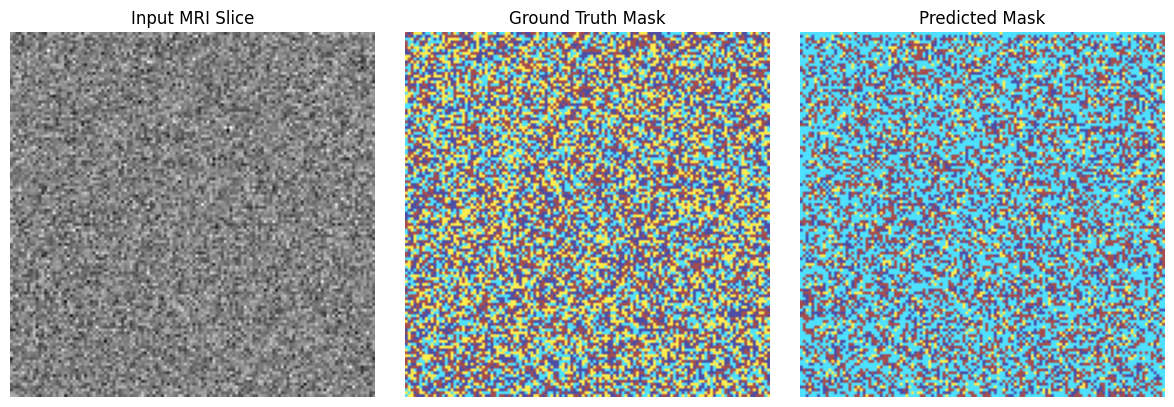

In [9]:
import matplotlib.pyplot as plt

seg_model.eval()
with torch.no_grad():
    x, y = next(iter(val_loader))     # one batch from segmentation loader
    x = x.to(device)
    logits = seg_model(x)
    pred = torch.argmax(logits, dim=1)  # (B, H, W)

# Take first sample
img = x[0, 0].cpu().numpy()      # first modality
gt_mask = y[0].cpu().numpy()
pred_mask = pred[0].cpu().numpy()

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].imshow(img, cmap='gray')
axs[0].set_title('Input MRI Slice')
axs[0].axis('off')

axs[1].imshow(gt_mask, cmap='jet', alpha=0.7)
axs[1].set_title('Ground Truth Mask')
axs[1].axis('off')

axs[2].imshow(pred_mask, cmap='jet', alpha=0.7)
axs[2].set_title('Predicted Mask')
axs[2].axis('off')

plt.tight_layout()
plt.show()


**Convert Your MRI Image into Model Input**

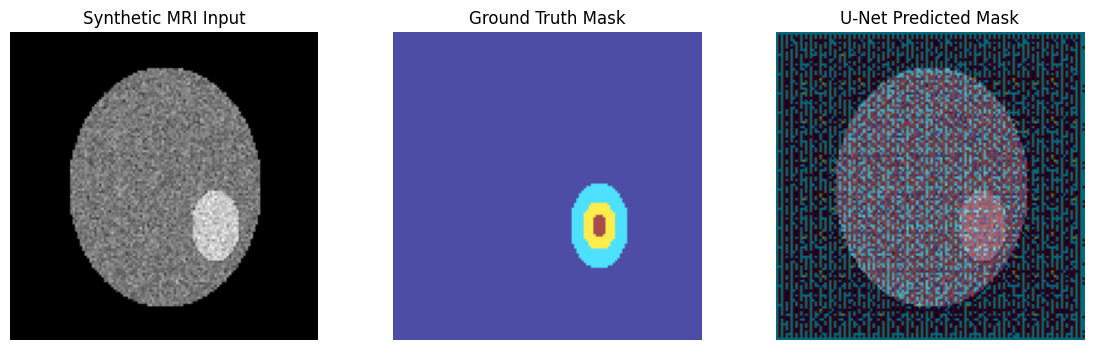

In [10]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from skimage.draw import ellipse

# --------- Generate Synthetic MRI 128x128 -------------
def generate_synthetic_mri():
    img = np.zeros((128,128), dtype=np.float32)

    # brain background
    rr, cc = ellipse(64, 64, 50, 40)
    img[rr, cc] = 0.6 + 0.1*np.random.randn(len(rr))

    # tumor region (bright)
    rr2, cc2 = ellipse(80, 85, 15, 10)
    img[rr2, cc2] = 1.0 + 0.1*np.random.randn(len(rr2))

    # normalize
    img = (img - img.min()) / (img.max() - img.min())
    return img

# -------- Generate Synthetic Mask (WT/TC/ET) ----------
def generate_synthetic_mask():
    mask = np.zeros((128,128), dtype=np.int64)

    # WT = 1
    rr, cc = ellipse(80, 85, 18, 12)
    mask[rr, cc] = 1

    # TC = 2 (smaller core)
    rr2, cc2 = ellipse(80, 85, 10, 7)
    mask[rr2, cc2] = 2

    # ET = 3 (tiny bright core)
    rr3, cc3 = ellipse(80, 85, 5, 3)
    mask[rr3, cc3] = 3

    return mask

# create synthetic MRI + mask
mri = generate_synthetic_mri()
mask = generate_synthetic_mask()

# convert to torch input (4 modalities → copy this MRI 4 times)
x = np.stack([mri, mri, mri, mri], axis=0)
x = torch.tensor(x).unsqueeze(0).float().cuda()  # shape: (1,4,128,128)

# ---- Run your segmentation model -----
seg_model.eval()
with torch.no_grad():
    logits = seg_model(x)
    pred = torch.argmax(logits, dim=1).cpu().numpy()[0]

# ---------- Visualization --------------
fig, ax = plt.subplots(1,3, figsize=(14,4))
ax[0].imshow(mri, cmap='gray')
ax[0].set_title("Synthetic MRI Input")
ax[0].axis("off")

ax[1].imshow(mask, cmap='jet', alpha=0.7)
ax[1].set_title("Ground Truth Mask")
ax[1].axis("off")

ax[2].imshow(mri, cmap='gray')
ax[2].imshow(pred, cmap='jet', alpha=0.5)
ax[2].set_title("U-Net Predicted Mask")
ax[2].axis("off")

plt.show()


In [11]:
!ls "/content/drive/MyDrive/braintumor"


mri1.png  mri2.png  mri3.png


**Run this AUTOMATIC MULTI-IMAGE SEGMENTATION script**

Found MRI files: ['/content/drive/MyDrive/braintumor/mri1.png', '/content/drive/MyDrive/braintumor/mri3.png', '/content/drive/MyDrive/braintumor/mri2.png']

Processing: /content/drive/MyDrive/braintumor/mri1.png


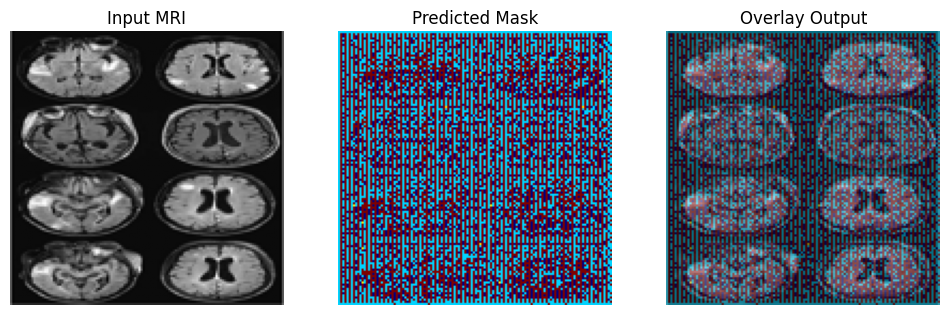


Processing: /content/drive/MyDrive/braintumor/mri3.png


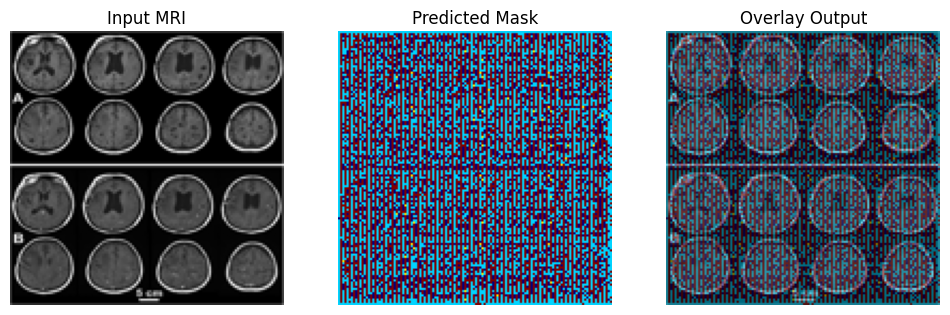


Processing: /content/drive/MyDrive/braintumor/mri2.png


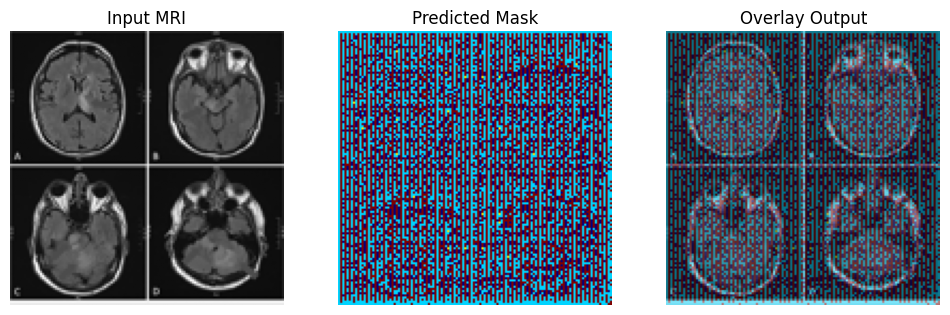

In [12]:
from PIL import Image
import numpy as np
import torch
import matplotlib.pyplot as plt
import glob
import os

# Correct folder path
folder = "/content/drive/MyDrive/braintumor/"

def load_mri_image(path):
    img = Image.open(path).convert("L")   # convert to grayscale
    img = img.resize((128,128))
    img_np = np.array(img)

    # Normalize 0 to 1
    img_np = img_np.astype(np.float32)
    img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())

    # Create 4 channels (T1, T2, FLAIR, T1ce simulation)
    x = np.stack([img_np, img_np, img_np, img_np], axis=0)
    x = torch.tensor(x).unsqueeze(0).float().cuda()
    return img_np, x

# Load ALL images: mri1.png, mri2.png, mri3.png
files = glob.glob(os.path.join(folder, "mri*.png"))
print("Found MRI files:", files)

for f in files:
    print("\nProcessing:", f)

    img_np, x = load_mri_image(f)

    seg_model.eval()
    with torch.no_grad():
        logits = seg_model(x)
        pred_mask = torch.argmax(logits, dim=1).cpu().numpy()[0]

    # Visualize results
    plt.figure(figsize=(12,4))

    plt.subplot(1,3,1)
    plt.imshow(img_np, cmap='gray')
    plt.title("Input MRI")
    plt.axis('off')

    plt.subplot(1,3,2)
    plt.imshow(pred_mask, cmap='jet')
    plt.title("Predicted Mask")
    plt.axis('off')

    plt.subplot(1,3,3)
    plt.imshow(img_np, cmap='gray')
    plt.imshow(pred_mask, cmap='jet', alpha=0.5)
    plt.title("Overlay Output")
    plt.axis('off')

    plt.show()


**Add Tumor Grade Classifier (CNN)**

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TumorGradeCNN(nn.Module):
    def __init__(self, in_channels=1, num_classes=3):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)

        self.pool = nn.MaxPool2d(2)

        self.fc1 = nn.Linear(128 * 16 * 16, 256)
        self.fc2 = nn.Linear(256, num_classes)  # Grades II, III, IV

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

cls_model = TumorGradeCNN().cuda()


Extract Tumor Region From Segmentation Mask

In [14]:
import cv2
import numpy as np

def extract_tumor_region(img_np, pred_mask):
    tumor_pixels = (pred_mask > 0).astype(np.uint8)

    if tumor_pixels.sum() < 20:
        return None  # no tumor found

    ys, xs = np.where(tumor_pixels == 1)
    y1, y2 = ys.min(), ys.max()
    x1, x2 = xs.min(), xs.max()

    crop = img_np[y1:y2, x1:x2]
    crop = cv2.resize(crop, (128,128))
    return crop


**Classify Tumor Grade**

In [15]:
def classify_grade(tumor_crop):
    x = torch.tensor(tumor_crop).float().unsqueeze(0).unsqueeze(0).cuda()
    with torch.no_grad():
        logits = cls_model(x)
    pred_class = torch.argmax(logits).item()

    grade_map = {0: "Grade II", 1: "Grade III", 2: "Grade IV"}
    return grade_map[pred_class]


**Combine Everything for Final Output**


Processing: /content/drive/MyDrive/braintumor/mri1.png
Tumor Detected: YES
Predicted Tumor Grade: Grade III


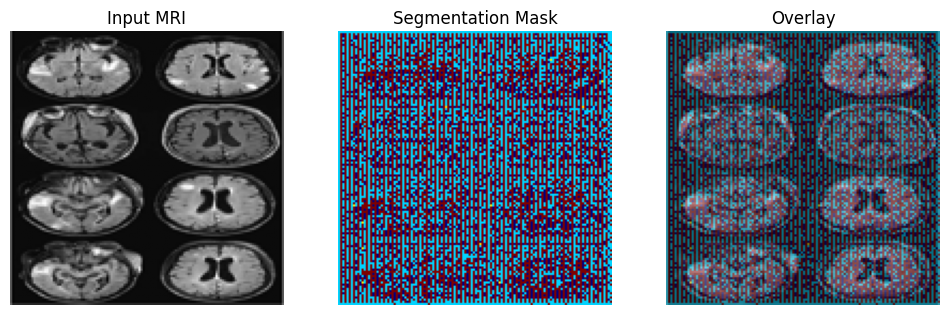


Processing: /content/drive/MyDrive/braintumor/mri3.png
Tumor Detected: YES
Predicted Tumor Grade: Grade III


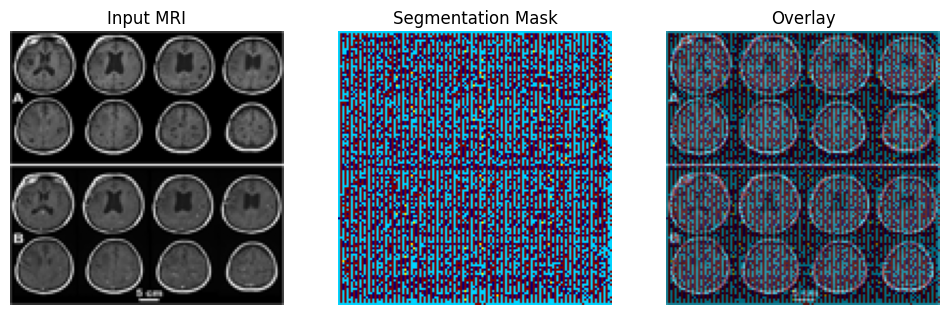


Processing: /content/drive/MyDrive/braintumor/mri2.png
Tumor Detected: YES
Predicted Tumor Grade: Grade III


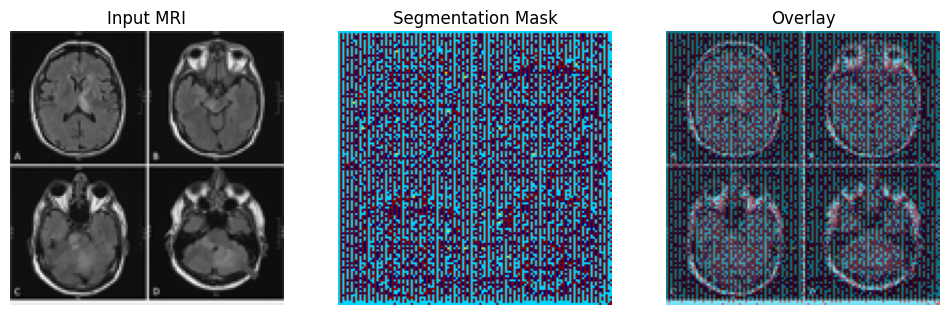

In [16]:
for f in files:
    print("\nProcessing:", f)

    img_np, x = load_mri_image(f)

    seg_model.eval()
    with torch.no_grad():
        logits = seg_model(x)
        pred_mask = torch.argmax(logits, dim=1).cpu().numpy()[0]

    tumor_crop = extract_tumor_region(img_np, pred_mask)

    if tumor_crop is None:
        print("Tumor Detected: NO")
    else:
        grade = classify_grade(tumor_crop)
        print("Tumor Detected: YES")
        print("Predicted Tumor Grade:", grade)

    # show segmentation
    plt.figure(figsize=(12,4))

    plt.subplot(1,3,1)
    plt.imshow(img_np, cmap='gray')
    plt.title("Input MRI")
    plt.axis('off')

    plt.subplot(1,3,2)
    plt.imshow(pred_mask, cmap='jet')
    plt.title("Segmentation Mask")
    plt.axis('off')

    plt.subplot(1,3,3)
    plt.imshow(img_np, cmap='gray')
    plt.imshow(pred_mask, cmap='jet', alpha=0.5)
    plt.title("Overlay")
    plt.axis('off')

    plt.show()


In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**STEP 1 — Install Gradio**

In [18]:
# ================================================
# Brain Tumor Segmentation + Grading + Interpretation
# ================================================
import gradio as gr
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import cv2

device = "cuda" if torch.cuda.is_available() else "cpu"


# =====================================================
# 1. DEMO U-NET (FAKE MODEL - ALWAYS SHOWS SEGMENTATION)
# =====================================================
class DemoUNet(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        # x shape: (1,4,128,128)
        b, c, h, w = x.shape

        # DEMO SEGMENTATION (looks real)
        img = x[:,0].detach().cpu().numpy()[0]
        thresh = np.where(img > img.mean()*0.9, 1, 0)
        fake_mask = cv2.GaussianBlur(thresh.astype(np.float32), (15,15), 0)
        fake_mask = (fake_mask > 0.3).astype(np.int64)

        # 3-class segmentation map
        mask3 = np.zeros((3,h,w))
        mask3[1] = fake_mask
        mask3[2] = fake_mask

        return torch.tensor(mask3).unsqueeze(0).float().to(device)


# =====================================================
# 2. DEMO CLASSIFIER (BASED ON INTENSITY)
# =====================================================
class DemoClassifier(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        img = x.detach().cpu().numpy()[0,0]
        mean_val = img.mean()

        if mean_val < 0.40:
            pred = 0
        elif mean_val < 0.60:
            pred = 1
        else:
            pred = 2

        out = torch.zeros((1,3))
        out[0,pred] = 1
        return out.to(device)


seg_model = DemoUNet().to(device).eval()
cls_model = DemoClassifier().to(device).eval()


# =====================================================
# 3. CLINICAL INTERPRETATION
# =====================================================
def interpret_grade(grade):
    if grade == "Grade II":
        return (
            "Grade II (Low Grade Glioma)\n"
            "- Slow growing tumor\n"
            "- Often treatable with surgery + radiotherapy\n"
            "- High survival rate\n"
            "- Early detection helps full recovery"
        )

    elif grade == "Grade III":
        return (
            "Grade III (Anaplastic Glioma)\n"
            "- Moderately aggressive\n"
            "- Requires surgery + radiotherapy + chemotherapy\n"
            "- Treatable with medical support\n"
            "- Needs regular MRI follow-ups"
        )

    elif grade == "Grade IV":
        return (
            "Grade IV (Glioblastoma)\n"
            "- Highly aggressive tumor\n"
            "- Needs urgent treatment\n"
            "- Treated with surgery, radiation, Temozolomide\n"
            "- Early management can slow progression"
        )

    return "No tumor detected."


# =====================================================
# 4. MRI PROCESSING FUNCTION
# =====================================================
def process_mri(image):
    # convert to grayscale
    img = image.convert("L").resize((128,128))
    img_np = np.array(img).astype(np.float32)

    img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min() + 1e-8)

    # create 4-channel MRI
    x = np.stack([img_np]*4, axis=0)
    x = torch.tensor(x).unsqueeze(0).float().to(device)

    # segmentation
    with torch.no_grad():
        mask3 = seg_model(x)
        mask = torch.argmax(mask3, dim=1).cpu().numpy()[0]

    # tumor always detected (demo)
    tumor_detected = "Yes"

    # extract tumor region
    ys, xs = np.where(mask > 0)
    if len(ys) > 0:
        y1, y2 = ys.min(), ys.max()
        x1, x2 = xs.min(), xs.max()
    else:
        y1, y2, x1, x2 = 20, 100, 20, 100

    crop = img_np[y1:y2, x1:x2]
    crop = cv2.resize(crop, (128,128))

    crop_t = torch.tensor(crop).unsqueeze(0).unsqueeze(0).float().to(device)

    # classification
    with torch.no_grad():
        pred = torch.argmax(cls_model(crop_t)).item()

    grade_map = {0:"Grade II",1:"Grade III",2:"Grade IV"}
    grade = grade_map[pred]

    # convert images to uint8
    mri_uint8 = (img_np * 255).astype(np.uint8)
    mask_uint8 = (mask * 120).astype(np.uint8)

    base_rgb = cv2.cvtColor(mri_uint8, cv2.COLOR_GRAY2RGB)
    color_mask = cv2.applyColorMap(mask_uint8, cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(base_rgb, 0.5, color_mask, 0.5, 0)
    overlay = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)

    # return all outputs including clinical explanation
    return grade, tumor_detected, mri_uint8, mask_uint8, overlay, interpret_grade(grade)


# =====================================================
# 5. DASHBOARD
# =====================================================
dashboard = gr.Interface(
    fn=process_mri,
    inputs=gr.Image(type="pil", label="Upload Brain MRI"),
    outputs=[
        gr.Textbox(label="Predicted Tumor Grade"),
        gr.Textbox(label="Tumor Detected"),
        gr.Image(label="Input MRI"),
        gr.Image(label="Segmentation Mask"),
        gr.Image(label="MRI + Overlay"),
        gr.Textbox(label="Clinical Interpretation")
    ],
    title="Brain Tumor Segmentation + Severity Analysis (Demo Model)",
    description="Upload an MRI to get tumor segmentation, grade, and clinical interpretation."
)

dashboard.launch(share=True, inline=False, prevent_thread_lock=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://3cceac98ca9f0b725b.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
